# Shape metrics for neural representations

This notebook demonstrates how to compute shape metrics for neural network representations proposed by Williams et al. (2021; [arXiv:2210.14739](https://arxiv.org/abs/2110.14739)).


In [2]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import sklearn.datasets
import seaborn as sns

from netrep.metrics import LinearMetric

## Linear metrics for neural network representations

We provide a simple intuitive example below to show how to use our `LinearMetric` class.

### Creating synthetic neural responses

We synthesize $N=2$ dimensional responses for $K=3$ networks, each responding to $M=256$ stimuli.
Network 1 and 2 will differ only by a simple random rotation in representation space, while Network 3's responses will be a random linear transform of Network 1.

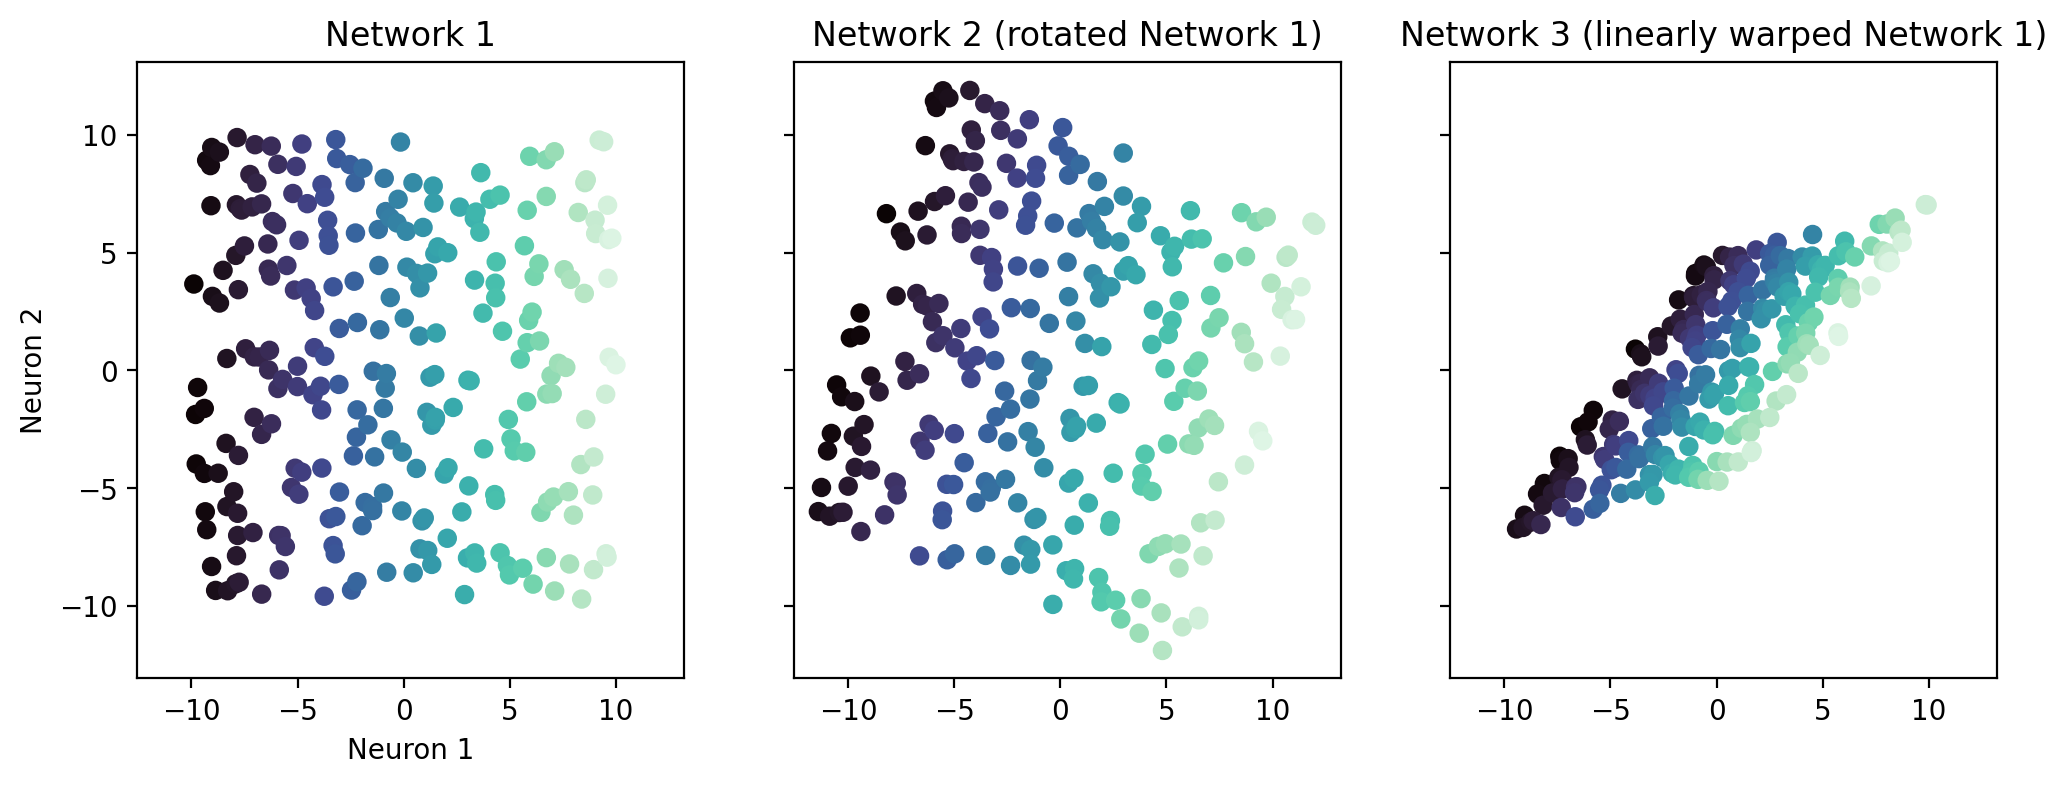

In [3]:
def rot(theta: float, X: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    return X @ R.T

seed = 42069
rng = np.random.default_rng(seed)

n_classes = 256
n_features = 2

# create data
X1, _ = sklearn.datasets.make_blobs(
                                    n_samples=n_classes, 
                                    n_features=n_features, 
                                    centers=n_classes, 
                                    cluster_std=0., 
                                    shuffle=False,
                                    random_state=seed,
                                    )

X1 = X1[np.argsort(X1[:,0])] # sort X1 by x-coord for colormap
X2 = rot(rng.random()*np.pi*2, X1)  # rotate X1
X3 = X1 @ rng.standard_exponential((n_features, n_features))  # warp X1

fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex="all", sharey="all", dpi=200)
cols = sns.color_palette("mako", n_classes)
ax[0].scatter(*X1.T, c=cols, label="1")
ax[1].scatter(*X2.T, c=cols, label="2")
ax[2].scatter(*X3.T, c=cols, label="2")

ax[0].set(xlabel="Neuron 1", ylabel="Neuron 2", title="Network 1")
ax[1].set(title="Network 2 (rotated Network 1)")
ax[2].set(title="Network 3 (linearly warped Network 1)");

### Computing the linear shape metric

We'll split the data into train and test sets, then compute shape distances with either $\alpha=0$ (CCA) or $\alpha=1$ (Procrustes distance).
When $\alpha=0$, the allowed group of nuissance transformations is any arbitrary linear map.
By contrast, when $\alpha=1$, the group of nuissance transformations is the set of orthogonal matrices.

Computing distances between $K$ networks requires $K \choose 2$ pairwise comparisons. 
We'll compute them manually here for clarity, but also provide simple a utility function in our library called `pairwise_distances()` that abstracts away the details.

In [4]:
# random indices for training set
idx_train = rng.choice(np.arange(n_classes), int(n_classes*.8), replace=False)

# everything left over is test set
idx_test = np.array(list(set(np.arange(n_classes)).difference(idx_train)))

X1_train, X1_test = X1[idx_train], X1[idx_test]
X2_train, X2_test = X2[idx_train], X2[idx_test]
X3_train, X3_test = X3[idx_train], X3[idx_test]

X_train = (X1_train, X2_train, X3_train)
X_test = (X1_test, X2_test, X3_test)

distmats = dict()

for alpha in (0, 1):
    distmat = np.zeros((3, 3))

    # loop through K choose 2 pairwise comparisons
    for i, j in itertools.combinations(range(3), 2):
        metric = LinearMetric(
            alpha=alpha, 
            center_columns=True,
            score_method="angular",
            )
        metric.fit(X_train[i], X_train[j])
        dist = metric.score(X_test[i], X_test[j])
        distmat[i, j] = dist
    
    distmat += distmat.T  # distance matrices are symmetric
    distmats[alpha] = distmat

### Plotting the distance matrices

By construction, the representations of Networks 1 and 2 differ only by a rotation, while Network 3 differs from Network 1 via an arbitrary linear transform.
We should thus expect qualitatively different results using `LinearMetric()` when $\alpha=0$ vs. $\alpha=1$.
Specifically, when $\alpha=1$ (i.e. Procrustes distance allowing for only rotational alignments), the computed distance between Networks 1 and 2 should be zero while distances between Networks 1 vs 3 and 2 vs 3 should be non-zero.
When $\alpha=0$, any arbitrary linear transform is allowed in the group of nuisance transforms; thus, we should expect the distance between all networks to be zero.

The below plots of the computed distances using `LinearMetric` show that this is indeed the case.

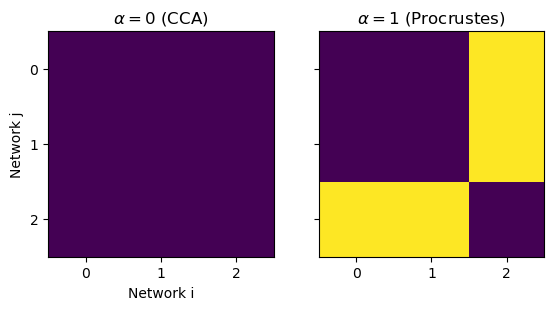

In [6]:
fig, ax = plt.subplots(1, 2, sharex="all", sharey="all")

_VMAX = np.max([distmats[0], distmats[1]])
for alpha in (0, 1):
    ax[alpha].imshow(distmats[alpha], vmin=0, vmax=_VMAX)

ax[0].set(title=r"$\alpha=0$ (CCA)")
ax[0].set(xticks=range(3), yticks=range(3))
ax[0].set(xlabel="Network i", ylabel="Network j")

ax[1].set(title=r"$\alpha=1$ (Procrustes)");